# ML Competition

In [83]:
import os
import numpy as np

def load_data(data_path):

    FEATURES = range(2, 33)
    N_TIME_SERIES = 3500

    # Create the training and testing samples
    LS_path = os.path.join(data_path, 'LS')
    TS_path = os.path.join(data_path, 'TS')
    X_train, X_test = [np.zeros((N_TIME_SERIES, (len(FEATURES) * 512))) for i in range(2)]

    for f in FEATURES:
        data = np.loadtxt(os.path.join(LS_path, 'LS_sensor_{}.txt'.format(f)))
        X_train[:, (f-2)*512:(f-2+1)*512] = data
        data = np.loadtxt(os.path.join(TS_path, 'TS_sensor_{}.txt'.format(f)))
        X_test[:, (f-2)*512:(f-2+1)*512] = data
    
    y_train = np.loadtxt(os.path.join(LS_path, 'activity_Id.txt'))

    print('X_train size: {}.'.format(X_train.shape))
    print('y_train size: {}.'.format(y_train.shape))
    print('X_test size: {}.'.format(X_test.shape))

    return X_train, y_train, X_test

# Loading Data

In [84]:
X_train_raw, y_train_raw, X_test_raw = load_data('data')

X_train size: (3500, 15872).
y_train size: (3500,).
X_test size: (3500, 15872).


## Missing values

In [85]:
# Count missing values
print(np.sum(X_train_raw == -999999.99))
print(np.sum(X_train_raw == -999999.99)*100/(len(X_train_raw)*X_train_raw.shape[1]))
np.sum(X_test_raw == -999999.99)

4957990
8.924953197004609


0

In [86]:
def missing(X_train, y_train):
    
    subject_1 = [[], [], [], [], [], [], [], [], [], [], [], [], [], []]
    subject_2 = [[], [], [], [], [], [], [], [], [], [], [], [], [], []]
    subject_3 = [[], [], [], [], [], [], [], [], [], [], [], [], [], []]
    subject_4 = [[], [], [], [], [], [], [], [], [], [], [], [], [], []]
    subject_5 = [[], [], [], [], [], [], [], [], [], [], [], [], [], []]
    activities = [[], [], [], [], [], [], [], [], [], [], [], [], [], []]
    sub_id = np.loadtxt(os.path.join('data', 'LS', 'subject_Id.txt'))
    
    for i in range(len(y_train)):
        activities[int(y_train[i] - 1)].append(i)
        if int(sub_id[i]) == 1:
            subject_1[int(y_train[i] - 1)].append(i)
        elif int(sub_id[i]) == 2:
            subject_2[int(y_train[i] - 1)].append(i)
        elif int(sub_id[i]) == 3:
            subject_3[int(y_train[i] - 1)].append(i)
        elif int(sub_id[i]) == 4:
            subject_4[int(y_train[i] - 1)].append(i)
        elif int(sub_id[i]) == 5:
            subject_5[int(y_train[i] - 1)].append(i)

    X_train[X_train == -999999.99] = np.nan

    for subject in [subject_1, subject_2, subject_3, subject_4, subject_5]:
        for activity in subject:
            if activity:
                data_mat = X_train[activity]
                for i in range(len(data_mat[0])):
                    if len(data_mat[:, i]) != len(data_mat[np.isnan(data_mat[:, i]), i]) and \
                            True in np.isnan(X_train[activity, i]):
                        mean_col = np.nanmean(data_mat[:, i])
                        index_nan = []
                        isnan_X_train = np.isnan(X_train[activity, i])
                        for k in range(len(isnan_X_train)):
                            if isnan_X_train[k]:
                                index_nan.append(activity[k])
                        X_train[index_nan, i] = mean_col

    for i in range(len(X_train[0])):
        for activity in activities:
            if True in np.isnan(X_train[activity, i]):
                index_nan = []
                isnan_X_train = np.isnan(X_train[activity, i])
                for k in range(len(isnan_X_train)):
                    if isnan_X_train[k]:
                        index_nan.append(activity[k])
                mean_activity = np.nanmean(X_train[activity, i])
                X_train[index_nan, i] = mean_activity
    return X_train

In [87]:
X_train = missing(X_train_raw, y_train_raw) 

## Outliers detection

In [88]:
# min and max of X_train and X_test
import matplotlib.pyplot as plt
import pandas as pd
print(np.min(X_train), np.min(X_test_raw))
print(np.max(X_train), np.max(X_test_raw))

-32091.38 -110348.95
1713.45 1597.99


-53.275
177.0


Text(0.5, 0, 'ID activities')

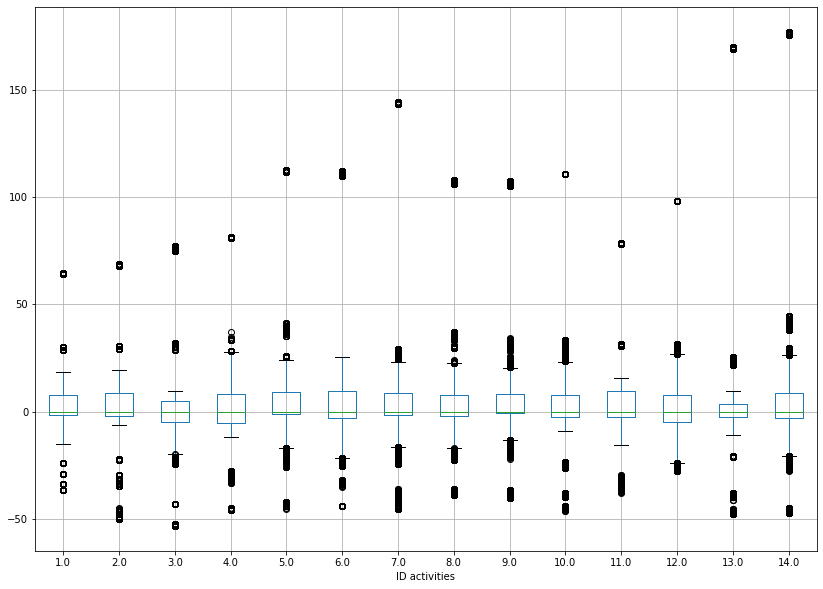

In [89]:
# Boxplot of the median per activities
df_tot = pd.DataFrame(X_train)
df_tot['id_activity'] = y_train_raw
df_median = df_tot.groupby('id_activity').median()
print(np.min(df_median.min()))
print(np.max(df_median.max()))
df_median = df_median.transpose()
ax = df_median.boxplot(figsize=(14,10))
ax.set_xlabel('ID activities')

## Handling outliers

In [90]:
def outlier(X):
    n_rows = len(X)
    for i in range(n_rows):
        for j in range(31):
            sensor_values = X[i, j*512:(j+1)*512]
            sensor_values[sensor_values>200] = np.nan
            sensor_values[sensor_values<-200] = np.nan
            df = pd.DataFrame(sensor_values)
            df = (df.bfill() + df.ffill()) / 2
            if df.isnull().values.any():
                df = df.bfill()
            if df.isnull().values.any():
                df = df.ffill()
            sensor_values = df.to_numpy()[:,0]
            X[i, j*512:(j+1)*512] = sensor_values
    return X

In [91]:
X_train = outlier(X_train)
X_test = outlier(X_test_raw)

## Feature extraction

In [ ]:
from scipy.stats import kurtosis, iqr

def summarize(X):
    h = len(X)
    new_X = []
    for i in range(0,h):
        row_values = []
        for j in range(0,31):
            sensor_values = X[i, j*512:(j+1)*512]
            sensor_fft = np.abs(np.fft.fft(sensor_values))
            sensor_fft[::-1].sort()
            sensor_fft = sensor_fft[:3]
            row_values.append(np.mean(sensor_values))
            row_values.append(np.std(sensor_values))
            row_values.append(np.median(sensor_values))
            row_values.append(kurtosis(sensor_values))
            row_values.append(iqr(sensor_values))

            for fft_value in sensor_fft:
                row_values.append(fft_value)

        new_X.append(row_values)
    return np.asarray(new_X)

In [ ]:
X_train_sum = summarize(X_train)
X_train_unscale = np.array(X_train_sum)
X_test_sum = summarize(X_test)

## Scaling

In [ ]:
from sklearn.preprocessing import PowerTransformer
power_scaler = PowerTransformer(method='yeo-johnson')
X_train_power = power_scaler.fit_transform(X_train_sum)
X_test_power = power_scaler.fit_transform(X_test_sum)

## Model evaluation - Cross validation

In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score
def last(arr, low, high, x, n) :
# reference : https://www.geeksforgeeks.org/find-first-and-last-positions-of-an-element-in-a-sorted-array/
    if (high >= low) :
        mid = low + (high - low) // 2
        if (( mid == n - 1 or x < arr[mid + 1]) and arr[mid] == x) :
            return mid
        elif (x < arr[mid]) :
            return last(arr, low, (mid - 1), x, n)
        else :
            return last(arr, (mid + 1), high, x, n)      
    return -1

def local_test(X_train, y_train):
    # X_train and y_train will be sorted by the subject ID
    subject_id = np.loadtxt(os.path.join('data', 'LS', 'subject_Id.txt'))
    sort_by_subject = np.c_[subject_id, X_train]
    sort_by_subject = np.c_[sort_by_subject, y_train]
    sort_by_subject = sort_by_subject[sort_by_subject[:, 0].argsort()]
    indices = [last(sort_by_subject[:,0], 0, len(sort_by_subject)-1, i, len(sort_by_subject)) + 1 for i in range(1,6)]
    sort_by_subject = np.delete(sort_by_subject, 0, axis=1)
    X_train = sort_by_subject[:, :sort_by_subject.shape[1]-1]
    y_train = sort_by_subject[:, sort_by_subject.shape[1]-1]
    return X_train, y_train, indices

def loo_cv(m, X_trains, y_trains):
    # Leave-One-Out Cross-Validation
    scores = []

    for i in range(0, 5):
        X_LS = np.concatenate([X_trains[j] for j in range(0, 5) if j != i]) 
        y_LS = np.concatenate([y_trains[j] for j in range(0, 5) if j != i])

        X_TS = X_trains_power[i]
        y_TS = y_trains[i]

        m.fit(X_LS, y_LS)
        y_predicted = m.predict(X_TS)

        score = accuracy_score(y_TS, y_predicted)
        print(str(i) + " out: " + str(score))

        #print(confusion_matrix(y_TS, y_predicted)) # Print confusion matrix can be useful to see the misclassifications
        scores.append(score)

    print("Mean score: " + str(np.mean(scores)))
    print("Std Dev score: " + str(np.std(scores)))

    return np.mean(scores)

In [ ]:
# Separate X_train_power by subject_id to perform the cross validation
X_train, y_train, indices = local_test(X_train_power, y_train_raw)
i1 = indices[0]
i2 = indices[1]
i3 = indices[2]
i4 = indices[3] 
X_train1 = X_train[:i1, :]
X_train2 = X_train[i1:i2, :]
X_train3 = X_train[i2:i3, :]
X_train4 = X_train[i3:i4, :]
X_train5 = X_train[i4:, :]

X_trains_power = [X_train1, X_train2, X_train3, X_train4, X_train5]

y_train1 = y_train[:i1]
y_train2 = y_train[i1:i2]
y_train3 = y_train[i2:i3]
y_train4 = y_train[i3:i4]
y_train5 = y_train[i4:]

y_trains = [y_train1, y_train2, y_train3, y_train4, y_train5]

# Train set and test set to perform simple accuracy score (80% LS and 20% TS)
X_train_LS = X_train[:i4, :]
X_train_TS = X_train[i4:, :]
y_train_LS = y_train[:i4]
y_train_TS = y_train[i4:]

Prove of poor efficiency on unscaled data for distance based algorithms

In [ ]:
X_train_unscale, _, indices = local_test(X_train_unscale, y_train_raw)
i1 = indices[0]
i2 = indices[1]
i3 = indices[2]
i4 = indices[3] 
X_train1_unscale = X_train_unscale[:i1, :]
X_train2_unscale = X_train_unscale[i1:i2, :]
X_train3_unscale = X_train_unscale[i2:i3, :]
X_train4_unscale = X_train_unscale[i3:i4, :]
X_train5_unscale = X_train_unscale[i4:, :]

X_trains_unscale = [X_train1_unscale, X_train2_unscale, X_train3_unscale, X_train4_unscale, X_train5_unscale]

In [51]:
from sklearn.neighbors import KNeighborsClassifier

m = KNeighborsClassifier(n_neighbors=3, n_jobs=-1)

m.fit(X_train_LS, y_train_LS)
y_predicted = m.predict(X_train_TS)
print("Scaled accuracy: " + str(accuracy_score(y_train_TS, y_predicted)))

m.fit(X_train_unscale[:i4], y_train[:i4])
y_predicted = m.predict(X_train_unscale[i4:])
print("Unscaled accuracy: " + str(accuracy_score(y_train[i4:], y_predicted)))

Scaled accuracy: 0.8988030467899891
Unscaled accuracy: 0.6082698585418934


## Model optimization

In [80]:
from sklearn.ensemble import RandomForestClassifier
best_depth = 0
best_score = 0

for depth in range(4, 15):
    m = RandomForestClassifier(n_estimators=500, max_depth=depth, random_state=1, n_jobs=-1)
    m.fit(X_train_LS, y_train_LS)
    s = loo_cv(m, X_trains_power, y_trains)
    print(str(depth) + ': ' + str(s))
    if s > best_score:
        best_depth = depth
        best_score = s
print(best_depth)
print(best_score)

0 out: 0.7828571428571428
1 out: 0.7122507122507122
2 out: 0.865934065934066
3 out: 0.5428109854604201
4 out: 0.809575625680087
Mean score: 0.7426857064364857
Std Dev score: 0.11149381747496795
4: 0.7426857064364857
0 out: 0.8228571428571428
1 out: 0.792022792022792
2 out: 0.889010989010989
3 out: 0.5848142164781907
4 out: 0.8465723612622416
Mean score: 0.7870555003262713
Std Dev score: 0.10596711461188114
5: 0.7870555003262713
0 out: 0.8857142857142857
1 out: 0.7977207977207977
2 out: 0.8989010989010989
3 out: 0.6187399030694669
4 out: 0.8813928182807399
Mean score: 0.8164937807372779
Std Dev score: 0.10512216749504881
6: 0.8164937807372779
0 out: 0.9114285714285715
1 out: 0.7991452991452992
2 out: 0.9087912087912088
3 out: 0.6235864297253635
4 out: 0.8879216539717084
Mean score: 0.8261746326124303
Std Dev score: 0.10925107981764036
7: 0.8261746326124303
0 out: 0.8914285714285715
1 out: 0.7578347578347578
2 out: 0.9131868131868132
3 out: 0.6381260096930533
4 out: 0.9096844396082698
Me

In [123]:
from sklearn.neural_network import MLPClassifier
# We tried a lot of MLP with different number of hidden layers and with differents number of neurons in each of the hidden layers
# We did not implement the cross validation immediately but we used it afterwards
best_i = 0
best_score = 0

for i in range(20, 100):
    m = MLPClassifier(random_state=1, max_iter=500, hidden_layer_sizes=(32, i))
    m.fit(X_train_LS, y_train_LS)
    y_predicted = m.predict(X_train_TS)
    score = accuracy_score(y_train_TS, y_predicted)
    print(str(i) + ': ' + str(score))
    if score > best_score:
        best_i = i
        best_score = score

print(best_i)
print(best_score)

99: 0.8715995647442872
99
0.8715995647442872


In [124]:
from sklearn import svm
# Same comments as MLP
best_i = 0
best_score = 0

for i in np.arange(0.01, 1, 0.01):
    m = svm.SVC(C=i, decision_function_shape='ovr', random_state=1)
    m.fit(X_train_LS, y_train_LS)
    y_predicted = m.predict(X_train_TS)
    score = accuracy_score(y_train_TS, y_predicted)
    print(str(i) + ': ' + str(score))
    if score > best_score:
        best_i = i
        best_score = score

print(best_i)
print(best_score)

0.01: 0.3144722524483134
0.02: 0.6289445048966268
0.03: 0.7584330794341676
0.04: 0.8313384113166485
0.05: 0.85310119695321
0.060000000000000005: 0.8607181719260065
0.06999999999999999: 0.8639825897714908
0.08: 0.8650707290533188
0.09: 0.8705114254624592
0.09999999999999999: 0.8726877040261154
0.11: 0.8759521218715995
0.12: 0.8813928182807399
0.13: 0.8846572361262242
0.14: 0.8857453754080522
0.15000000000000002: 0.8879216539717084
0.16: 0.8900979325353645
0.17: 0.8922742110990207
0.18000000000000002: 0.8922742110990207
0.19: 0.8955386289445049
0.2: 0.8988030467899891
0.21000000000000002: 0.9009793253536452
0.22: 0.9053318824809575
0.23: 0.9053318824809575
0.24000000000000002: 0.9064200217627857
0.25: 0.9085963003264418
0.26: 0.9096844396082698
0.27: 0.9107725788900979
0.28: 0.911860718171926
0.29000000000000004: 0.911860718171926
0.3: 0.9107725788900979
0.31: 0.9140369967355821
0.32: 0.9162132752992383
0.33: 0.9173014145810664
0.34: 0.9162132752992383
0.35000000000000003: 0.915125136017

In [60]:
m = svm.SVC(C=0.95, decision_function_shape='ovr', random_state=1)
loo_cv(m, X_trains_power, y_trains)

0 out: 0.9628571428571429
1 out: 0.7749287749287749
2 out: 0.932967032967033
3 out: 0.8481421647819063
4 out: 0.9183895538628944
Mean score: 0.8874569338795503
Std Dev score: 0.06770734854933125


0.8874569338795503

In [62]:
from sklearn.tree import DecisionTreeClassifier
# Same comments as MLP
best_i = 0
best_score = 0

for depth in range(4, 11):
    m = DecisionTreeClassifier(max_depth=depth, random_state=1)
    m.fit(X_train_LS, y_train_LS)
    y_predicted = m.predict(X_train_TS)
    score = accuracy_score(y_train_TS, y_predicted)
    print(str(depth) + ': ' + str(score))
    if score > best_score:
        best_i = depth
        best_score = score

print(best_i)
print(best_score)

4: 0.34929270946681173
5: 0.4548422198041349
6: 0.661588683351469
7: 0.6974972796517954
8: 0.5712731229597389
9: 0.4820457018498368
10: 0.5321001088139282
7
0.6974972796517954


In [64]:
from sklearn.neighbors import KNeighborsClassifier
# Same comments as MLP
best_knn = 0
best_score = 0

for knn in range(1, 20):
    m = KNeighborsClassifier(n_neighbors=knn, n_jobs=-1)
    m.fit(X_train_LS, y_train_LS)
    y_predicted = m.predict(X_train_TS)
    score = accuracy_score(y_train_TS, y_predicted)
    print(str(knn) + ': ' + str(score))
    if score > best_score:
        best_knn = depth
        best_score = score

print(best_knn)
print(best_score)

1: 0.9042437431991295
2: 0.8944504896626768
3: 0.8988030467899891
4: 0.8900979325353645
5: 0.8900979325353645
6: 0.8868335146898803
7: 0.8955386289445049
8: 0.8933623503808488
9: 0.8966267682263329
10: 0.8966267682263329
11: 0.8944504896626768
12: 0.8911860718171926
13: 0.8944504896626768
14: 0.8944504896626768
15: 0.8922742110990207
16: 0.8933623503808488
17: 0.8933623503808488
18: 0.8944504896626768
19: 0.8922742110990207
10
0.9042437431991295


In [71]:
m = KNeighborsClassifier(n_neighbors=10, n_jobs=-1)
loo_cv(m, X_trains_power, y_trains)

0 out: 0.8171428571428572
1 out: 0.6923076923076923
2 out: 0.9076923076923077
3 out: 0.8594507269789984
4 out: 0.8966267682263329
Mean score: 0.8346440704696377
Std Dev score: 0.07792202128523171


0.8346440704696377

In [ ]:
from sklearn.svm import SVC
m = SVC(C=1, random_state=1, shrinking=False, kernel='rbf', gamma='auto')

## Ensemble classifiers

In [81]:
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier

m1 = RandomForestClassifier(n_estimators=125, max_depth=7, random_state=1)
m = BaggingClassifier(n_estimators=20, base_estimator=m1)
# Leave-One-Out Cross-Validation
loo_cv(m, X_trains_power, y_trains)

0 out: 0.9057142857142857
1 out: 0.8048433048433048
2 out: 0.9120879120879121
3 out: 0.6381260096930533
4 out: 0.8933623503808488
Mean score: 0.8308267725438808
Std Dev score: 0.10385656986564047


0.8308267725438808

In [82]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn import svm
from sklearn.ensemble import VotingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier

# These models are scored using the cross validation. We call the function below.

m1 = RandomForestClassifier(n_estimators=500, max_depth=7, random_state=1, n_jobs=-1)
m2 = MLPClassifier(random_state=1, max_iter=500, hidden_layer_sizes=(132,40))
m3 = KNeighborsClassifier(n_neighbors=3, n_jobs=-1)
m = VotingClassifier(estimators=[('rf', m1), ('mlp', m2), ('knn,', m3)], weights=[2,3,2], voting='hard')
loo_cv(m, X_trains_power, y_trains)

0 out: 0.9457142857142857
1 out: 0.8034188034188035
2 out: 0.9252747252747253
3 out: 0.8691437802907916
4 out: 0.9434167573449401
Mean score: 0.8973936704087093
Std Dev score: 0.05451548685013476


0.8973936704087093

In [138]:
# Hyper-parameters optimization to find accurate parameters, this is long to run...
depth_values = [5, 6, 7]
layer_sizes = [((100, 30), (120, 40), (130, 40), (135, 50), (150, 40), (170, 70) ,(130, 50, 50))]
n_neighbors = [3, 4, 5, 6, 7, 8]

best_score = 0
best_depth = None
best_neighbors = None
best_layer = None

for depth in depth_values:
    for knn in n_neighbors:
        for layer_size in layer_sizes:
            print("################################")
            print("depth=" + str(depth) + " \nknn=" + str(knn) + " \nlayer_size=" + str(layer_size))
            m1 = RandomForestClassifier(max_depth=depth, random_state=1)
            m2 = MLPClassifier(random_state=1, max_iter=500, hidden_layer_sizes=layer_size)
            m3 = KNeighborsClassifier(n_neighbors=knn)
            m = VotingClassifier(estimators=[('rf', m1), ('mlp', m2), ('knn,', m3)], weights=[3,3,2], voting='hard')
            s = loo_cv(m)
            if s > best_score:
                best_score = s
                best_depth = depth
                best_neighbors = knn
                best_layer = layer_size

In [112]:
print(best_score)
print(best_depth) 
print(best_neighbors)
print(best_layer)

0.9012510437194289
7
3
260


# Retrain and submit

In [287]:
m.fit(X_train, y_train)
y_test = m.predict(X_test_power)

In [288]:
def write_submission(y, where, submission_name='eclf_3_fourier_iqr_layer_132_40_knn3_no_outliers.csv'):

    os.makedirs(where, exist_ok=True)

    SUBMISSION_PATH = os.path.join(where, submission_name)
    if os.path.exists(SUBMISSION_PATH):
        os.remove(SUBMISSION_PATH)

    y = y.astype(int)
    outputs = np.unique(y)

    # Verify conditions on the predictions
    if np.max(outputs) > 14:
        raise ValueError('Class {} does not exist.'.format(np.max(outputs)))
    if np.min(outputs) < 1:
        raise ValueError('Class {} does not exist.'.format(np.min(outputs)))
    
    # Write submission file
    with open(SUBMISSION_PATH, 'a') as file:
        n_samples = len(y)
        if n_samples != 3500:
            raise ValueError('Check the number of predicted values.')

        file.write('Id,Prediction\n')

        for n, i in enumerate(y):
            file.write('{},{}\n'.format(n+1, int(i)))

    print('Submission {} saved in {}.'.format(submission_name, SUBMISSION_PATH))

write_submission(y_test, 'submissions')

Submission eclf_3_fourier_iqr_layer_132_40_knn3_no_outliers.csv saved in submissions\eclf_3_fourier_iqr_layer_132_40_knn3_no_outliers.csv.
